In [1]:
import pandas as pd
import numpy as np
import os
from scipy import stats

pd.options.mode.chained_assignment = None

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Load data

In [3]:
quest  = pd.read_csv('../subj-data/quest/SL_GERF_player_questionnaire.csv')
player = pd.read_csv('GERF_group_player_psi_data.csv').set_index('Player')
group  = pd.read_csv('GERF_group_means.csv').set_index('Group')
segm   = pd.read_csv('GERF_beauty_segment_data.csv').set_index(['Group', 'Segment'])

In [4]:
ordp_names  = [ 'mean_dist_cmass', 'mean_dist_nearest', 'var_angle', 'vicsek_order' ]
psi_names   = [ 'Psi_max', 'Psi_min', 'Psi_avg', 'Psi_std' ]
psych_names = [ 'DavisPerspective', 'WattsSelf', 'WattsOthers', 'WattsWorld', 'WattsTotal' ]

In [5]:
ordp_dfs = {}

for g in group.index:  
    ordp_d = {}
    for p in ordp_names:
        if os.path.exists(f"flocking/{g}/{p}.txt"):
            op = np.loadtxt(f"flocking/{g}/{p}.txt")
            ind = list(range(len(op)))
            ordp_d[p] = op

    if len(ordp_d.keys()):
        ordp_dfs[g] = pd.DataFrame.from_dict(ordp_d, orient = 'index').transpose()

In [6]:
temp = ordp_dfs['A_8'].copy()
temp['mean_dist_cmass']   = temp['mean_dist_cmass'].apply(lambda x: x if x <= 1 else np.nan)
temp['mean_dist_nearest'] = temp['mean_dist_nearest'].apply(lambda x: x if x <= 1 else np.nan)
ordp_dfs['A_8'] = temp

temp = ordp_dfs['A_9'].copy()
temp['mean_dist_cmass']   = temp['mean_dist_cmass'].apply(lambda x: x if x <= 1 else np.nan)
temp['mean_dist_nearest'] = temp['mean_dist_nearest'].apply(lambda x: x if x <= 1 else np.nan)
ordp_dfs['A_9'] = temp

In [7]:
group_data = pd.read_csv(f"../experiment/groups_data.csv").set_index('Group')
FRAMERATE = 12
START_THRESHOLD = FRAMERATE * 15

psi = {}
for g in group_data[group_data.Psi_error == 0].index:
    start  = int(group_data.Filt_buffer[g] / 3 * 2 + START_THRESHOLD)
    length =  int(group_data.Duration[g]) - start + 1

    if os.path.exists(f"psi/{g}-psi.csv"):
        psis = pd.read_csv(f"psi/{g}-psi.csv")
        psis = psis[psis.type == 'Filtered']
        psis = psis[psis.frame >= start]
        psis = psis[psis.frame < start + length]
        psi[g] = np.array(psis.psi)


-----
# Visualising data

In [8]:
sns.set(font_scale = 1.3) 
sns.set_palette('colorblind')
sns.set_style('white')

## Questionnaire outcomes

We first exclude game play data to check if there are relationships between questionnaire responses.

In [9]:
def player_plots(data):
    pmelt = data.drop('Group', axis=1).drop('DavisPerspective', axis=1
                ).melt(id_vars='Player', var_name='Questionnaire', value_name='Value')
    sns.violinplot(data=pmelt, x='Questionnaire', y='Value')
    plt.show()

    pmelt = data.drop('Group', axis=1).melt(id_vars=['Player', 'DavisPerspective'],
                    var_name='Questionnaire', value_name='Value')

    g = sns.FacetGrid(data=pmelt, col='Questionnaire', hue='Questionnaire', sharey=True)
    g.map_dataframe(sns.regplot, x='DavisPerspective', y='Value')
    g.fig.set_size_inches(16,6)
    plt.show()


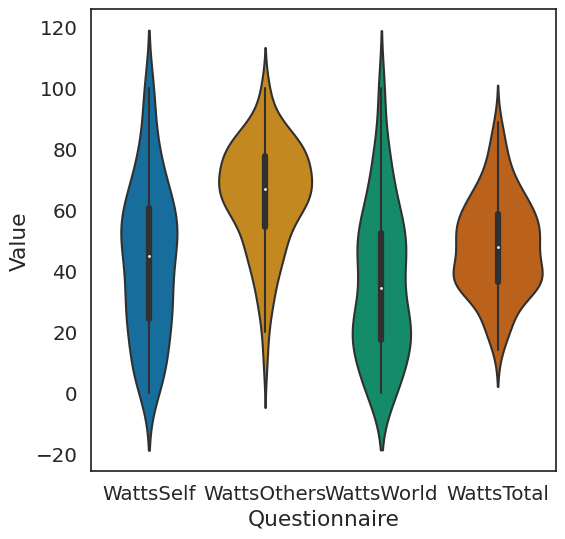

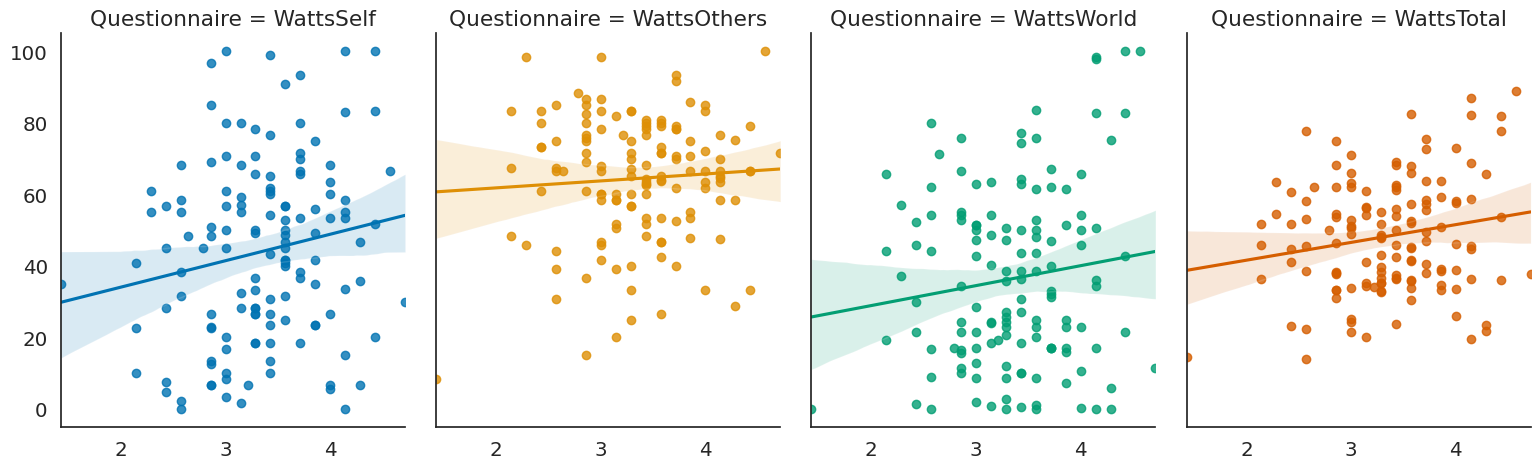

In [10]:
plt.rcParams['figure.figsize'] = 6, 6
player_plots(quest)

We study the questionnaire responses by whether the group emerged or not, excluding the players with `manual=1`.

In [11]:
def group_plots(data, cols_to_drop, var_name, hue, title):

    gmelt = data.drop(cols_to_drop, axis=1).melt(id_vars = ['Group', hue ],
                      var_name = var_name, value_name = 'Value')

    sns.violinplot(data = gmelt, x = var_name, y ='Value', hue = hue)
    plt.title(title)
    plt.show()

## Player plots - game outcome
#### Excluding games with manual emergence

Relationship between empathy, connectedness, and binary game outcome. 

`lm(Connectedess ~ Emerged * DavisPerspective)`

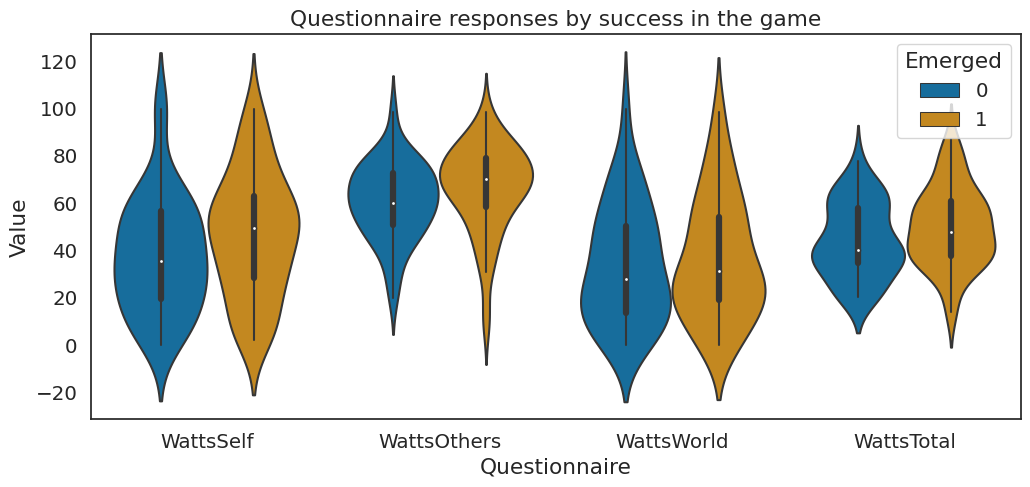

In [12]:
plt.rcParams['figure.figsize'] = 12, 5
group_plots(player[player['Manual'] == 0].drop('Manual', axis = 1), 
            ['Duration', 'DavisPerspective' ] + psi_names,
            'Questionnaire', 'Emerged', 
            'Questionnaire responses by success in the game')

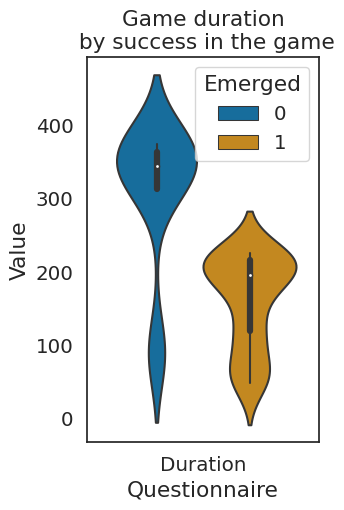

In [13]:
plt.rcParams['figure.figsize'] = 3, 5
group_plots(player[player['Manual'] == 0].drop('Manual', axis = 1), 
            psych_names + psi_names,
            'Questionnaire', 'Emerged', 
            'Game duration\n by success in the game')

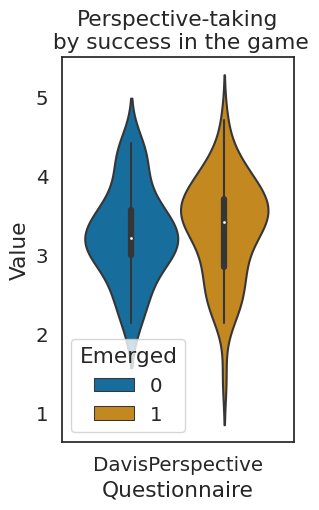

In [14]:
plt.rcParams['figure.figsize'] = 3, 5
group_plots(player[player['Manual'] == 0].drop('Manual', axis = 1), 
            psych_names[1:] + psi_names + ['Duration'],
            'Questionnaire', 'Emerged', 
            'Perspective-taking\n by success in the game')

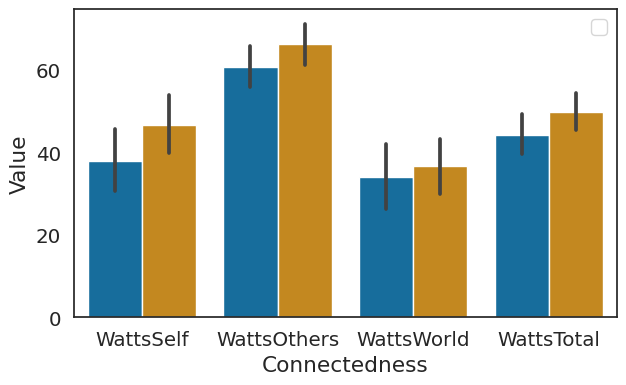

In [15]:
plt.rcParams['figure.figsize'] = 7, 4
melt = player[player.Manual == 0].drop(['Duration', 'DavisPerspective', 'Manual' ] + psi_names, axis=1)\
                                .melt(id_vars = ['Group', 'Emerged' ],
                                      var_name = 'Connectedness', value_name = 'Value')

fig = sns.barplot(data = melt, x = 'Connectedness', y='Value', hue = 'Emerged')
fig.legend('')

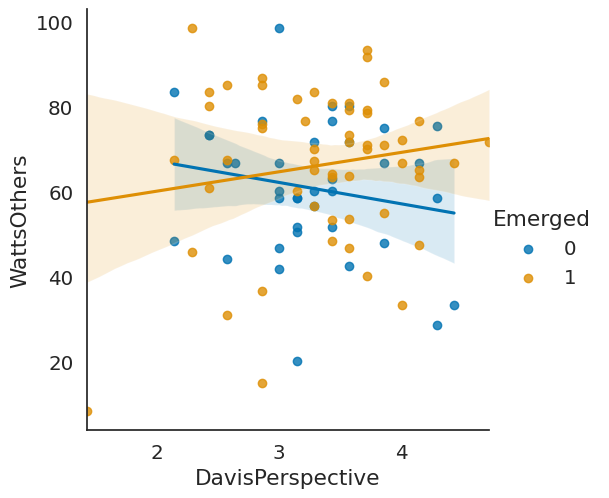

In [16]:
sns.lmplot(data=player[player['Manual'] == 0],
           y="WattsOthers", x="DavisPerspective", hue="Emerged")

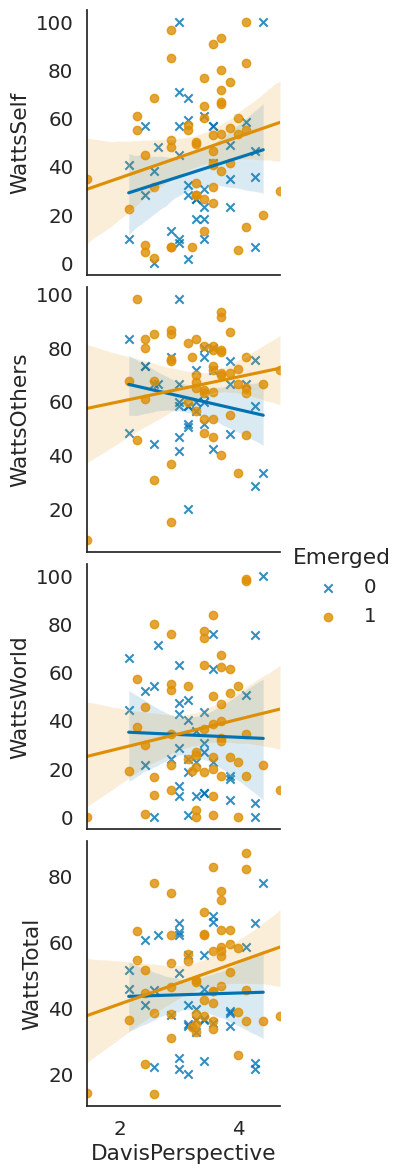

In [17]:
fig = sns.pairplot(player[player['Manual'] == 0],
                    y_vars = psych_names[1:], x_vars = psych_names[0],
                    kind="reg", hue="Emerged", markers=["x", "o"], height = 3,
                    diag_kind = None) # fix bug with dissapearing first graph

## Data by groups

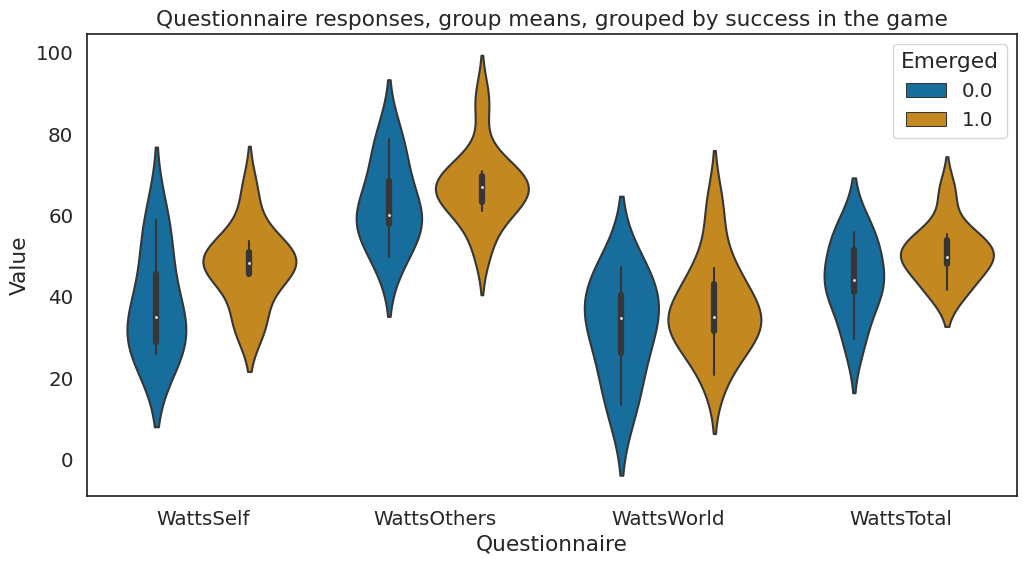

In [18]:
plt.rcParams['figure.figsize'] = 12, 6
group_plots(group[group.Manual == 0][psych_names + ['Emerged']].reset_index(), 
            [ 'DavisPerspective' ],
            'Questionnaire', 'Emerged', 'Questionnaire responses, group means, grouped by success in the game')

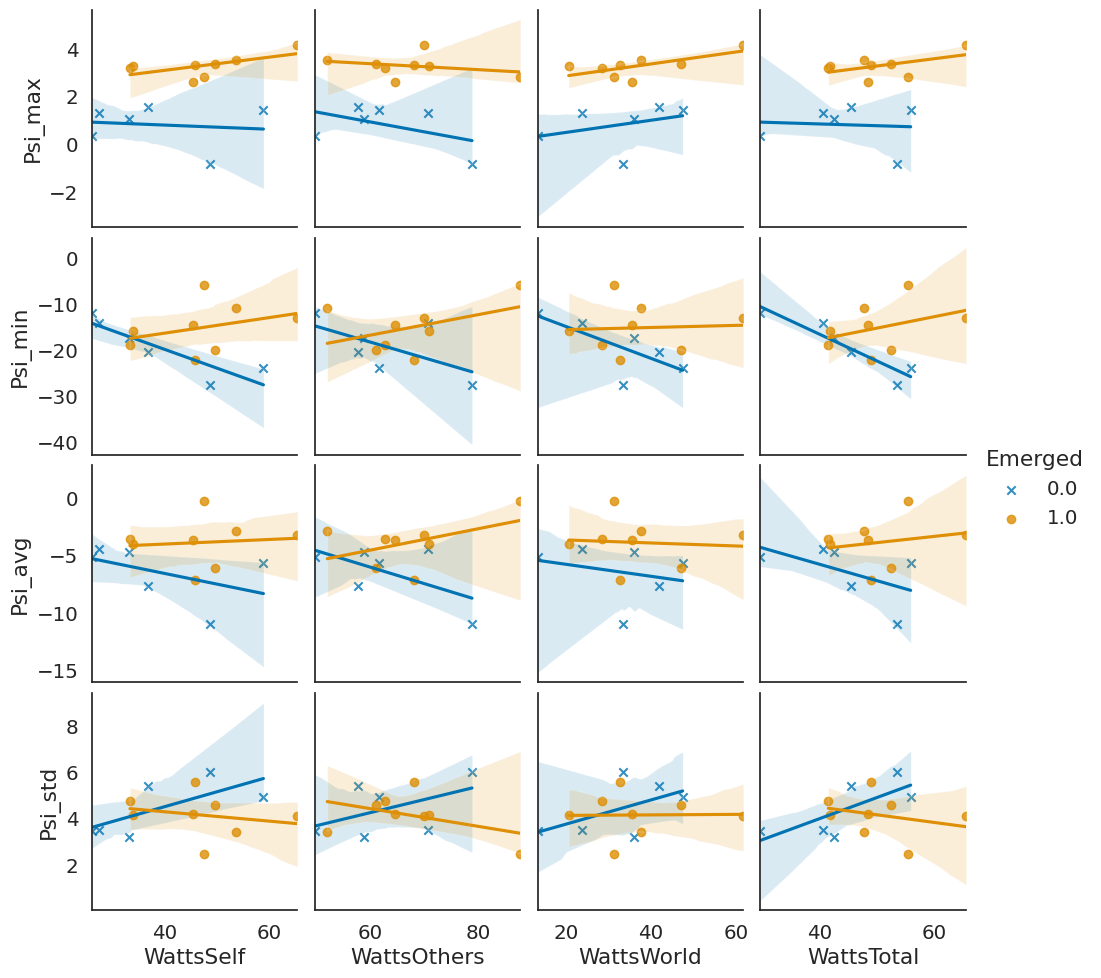

In [19]:
fig = sns.pairplot(group[group.Manual == 0], x_vars=psych_names[1:], y_vars=psi_names,
                    kind="reg", hue="Emerged",  markers = ['x', 'o'],
                    diag_kind = None) # fix bug with dissapearing first graph

## Data by segment

We aim to study the relationship between different mathematical quantifiers of collective movement and beauty ratings.
We use all data (so regardless of `manual`) and we don't care about game outcome here, just studying the properties of the flocking movement.

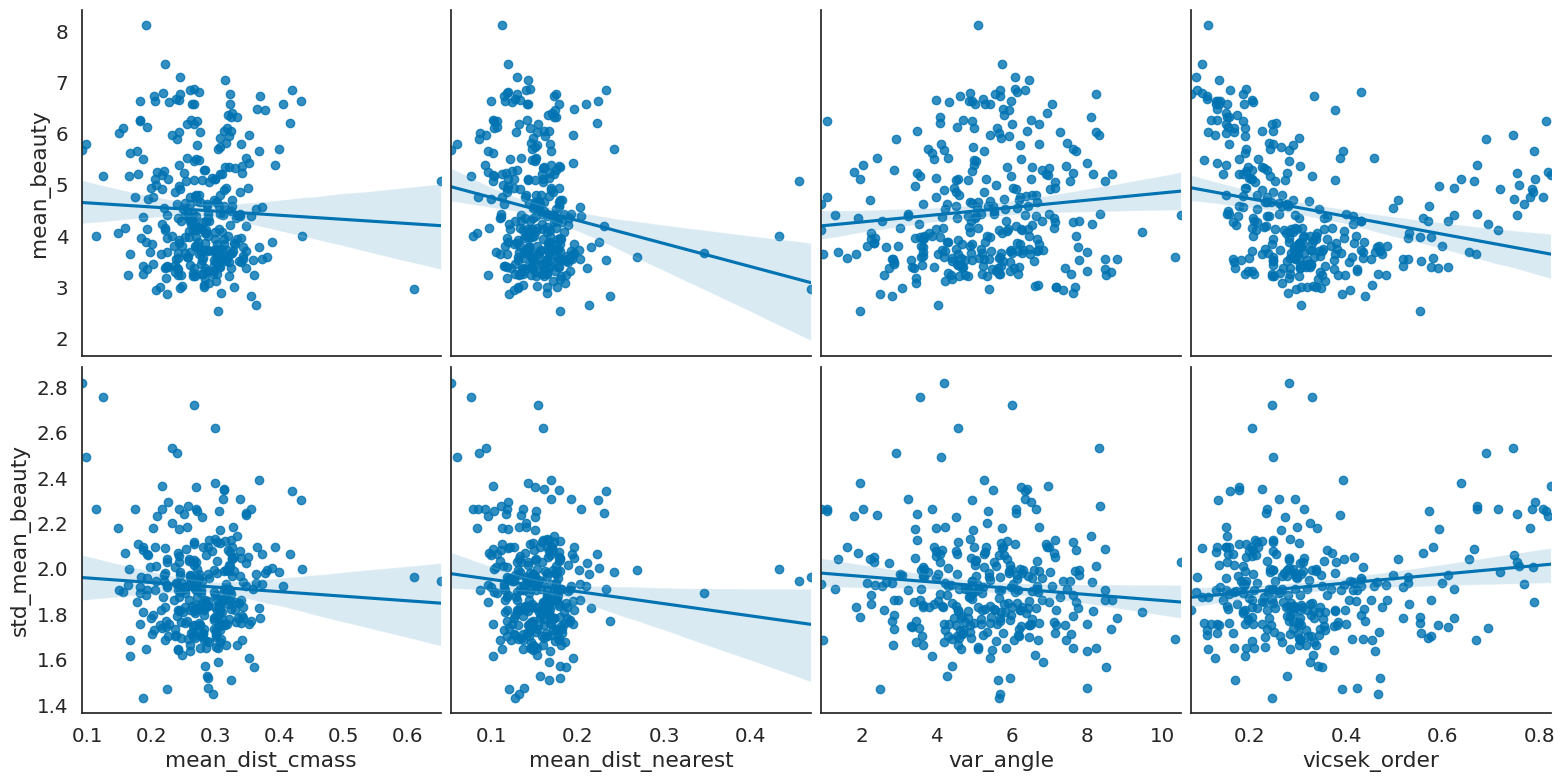

In [20]:
fig = sns.pairplot(segm, 
             x_vars=ordp_names, y_vars=[ "mean_beauty", "std_mean_beauty" ], 
             kind="reg",  height=4, # hue="Emerged", markers = ['x', 'o'],
             diag_kind = None) # fix bug with dissapearing first graph

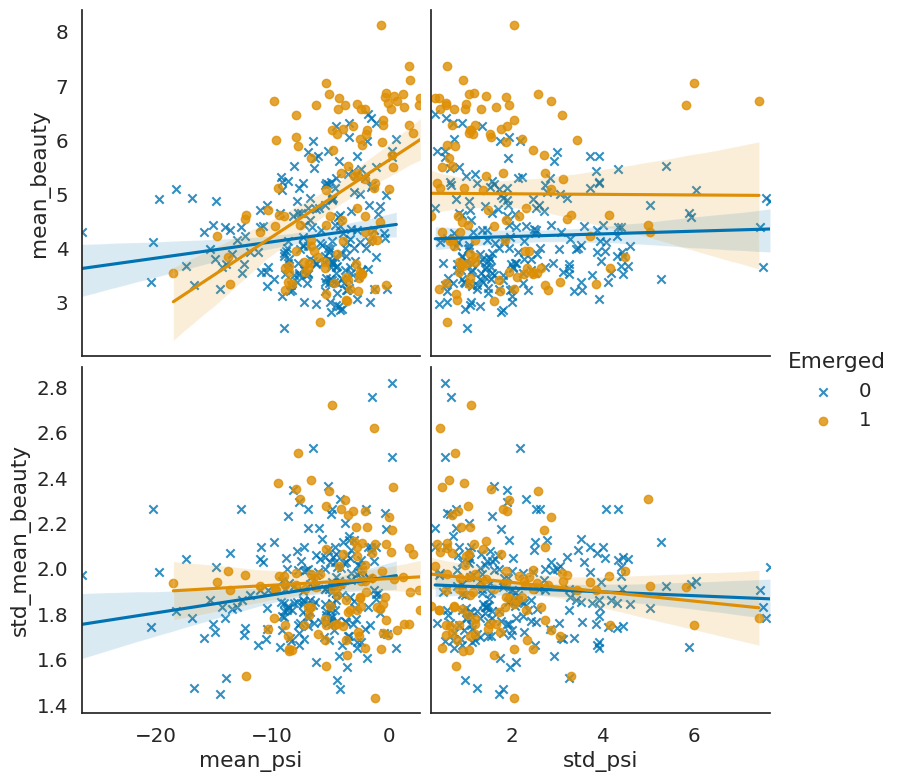

In [21]:
fig = sns.pairplot(segm, 
             x_vars = ['mean_psi', 'std_psi'], y_vars=[ "mean_beauty", "std_mean_beauty" ], 
             kind="reg", hue="Emerged", height=4,  markers = ['x', 'o'],
             diag_kind = None) # fix bug with dissapearing first graph

We also explore how the order parameters and $\Psi$ differ by segment between gameplays. To do that we align the last 7 segments of 10s in every order parameter array in `smelt`

In [22]:
seg = segm.copy().reset_index()
seg['psi'] = seg.mean_psi
seg = seg.drop(['mean_psi'], axis = 1)

In [23]:
seg['std_angle'] = np.sqrt(seg['var_angle'])
seg['std_std_angle'] = np.sqrt(seg['std_var_angle'])
# needs to be std dev not variance

In [24]:
smelt = seg.melt(id_vars=['Group', 'Segment'])
smelt['Emerged'] = smelt.Group.apply(lambda x: group.loc[x].Emerged);
smelt['Manual']  = smelt.Group.apply(lambda x: group.loc[x].Manual);

In [25]:
def get_num_segments(g):
    return int(seg[seg.Group==g].groupby('Group').count().Segment)

In [26]:
for g in seg.Group.unique():
    inds = smelt[smelt.Group == g][smelt.Segment < get_num_segments(g) - 7].index
    smelt = smelt.drop(inds)

/tmp/ipykernel_25569/1084806966.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  inds = smelt[smelt.Group == g][smelt.Segment < get_num_segments(g) - 7].index


In [27]:
smelt['Segment'] = smelt.apply(lambda row: row['Segment'] - get_num_segments(row['Group']) + 7, axis = 1);

We plot individual segment means, and averages with std dev, against time for the last 7 segments.

In [69]:
def plot_segment_order_mean(smelt, param, ylab):
    plt.rcParams['figure.figsize'] = 8,4
    sns.lineplot(x="Segment", y="value", hue="Emerged", style='Emerged',
                 data=smelt[smelt.variable==param], 
                 err_style="bars", markers = True, dashes = False, linewidth = 2)
    
    plt.xticks(range(0, 8), range(-7, 1))
    plt.ylabel(ylab)
    plt.xlabel('10s segment before finish')
    plt.tight_layout()

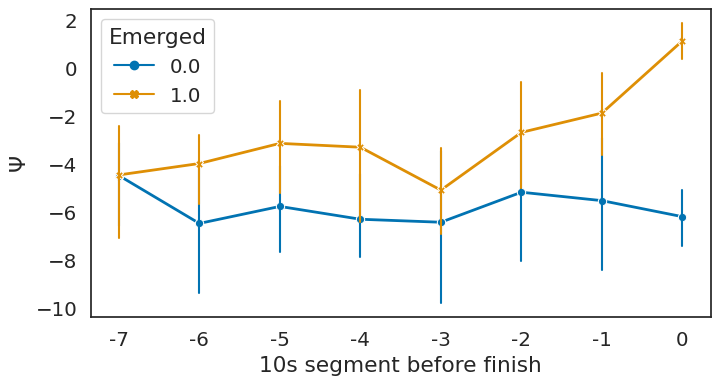

In [29]:
plot_segment_order_mean(smelt, 'psi', '$\\Psi$')

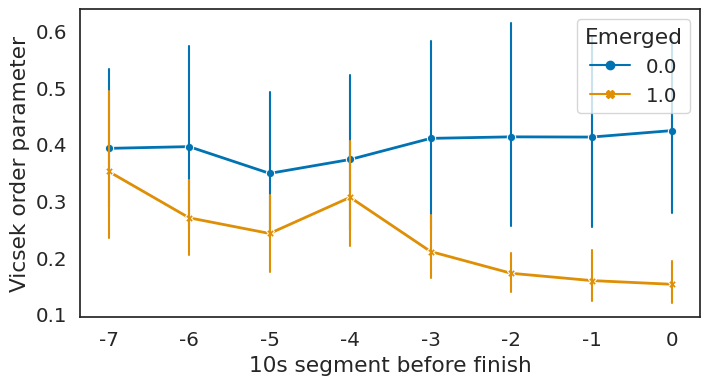

In [30]:
plot_segment_order_mean(smelt, 'vicsek_order', 'Vicsek order parameter')

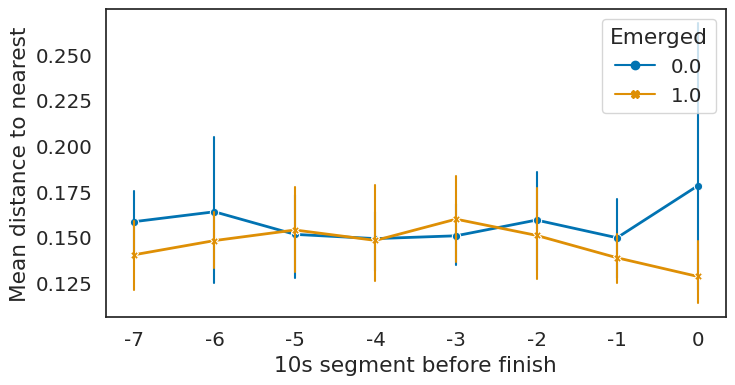

In [31]:
plot_segment_order_mean(smelt, 'mean_dist_nearest', 'Mean distance to nearest')

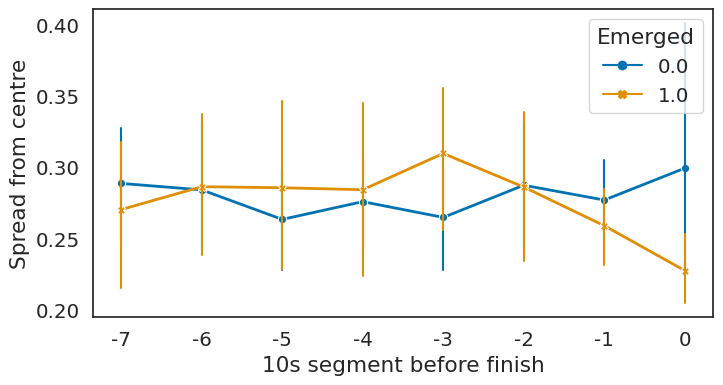

In [32]:
plot_segment_order_mean(smelt, 'mean_dist_cmass', 'Spread from centre')

In [33]:
def plot_segment_order_compare(smelt, params, groups = [], emerged = 1):
    plt.rcParams['figure.figsize'] = 6,5

    if not groups:
        groups = smelt[smelt.Emerged == emerged].Group.unique()
        
    for param in params:
        dat = smelt[smelt.variable == param]
        dat = dat[dat.Emerged == emerged]
        mean = float(dat.value.mean())
        std = float(dat.value.std())
        
        dat.value = (dat.value - mean) / std
        
        sns.lineplot(x="Segment", y="value", #style=,
             data = dat, label = param,
             err_style = "bars", markers = True, dashes = True, linewidth = 2, err_kws={'capsize':5})
             #errorbar = ("se", 2))

    plt.xlim(1, 8)
    plt.xticks(range(2, 8), range(-5, 1))
    plt.legend(loc='upper right')
    plt.xlabel('10s segment');
    plt.ylabel('');
    plt.tight_layout()

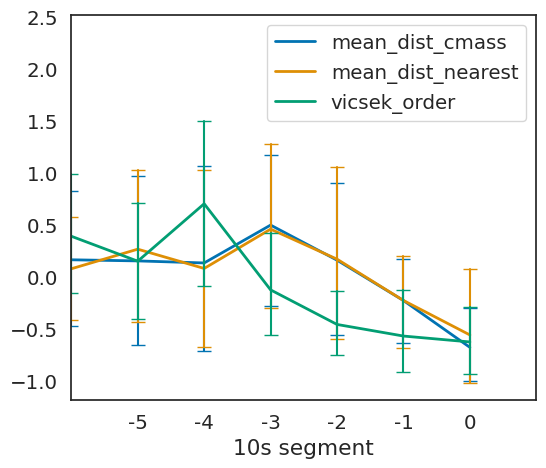

In [34]:
plot_segment_order_compare(smelt, ['mean_dist_cmass', 'mean_dist_nearest', 'vicsek_order' ], emerged = 1)

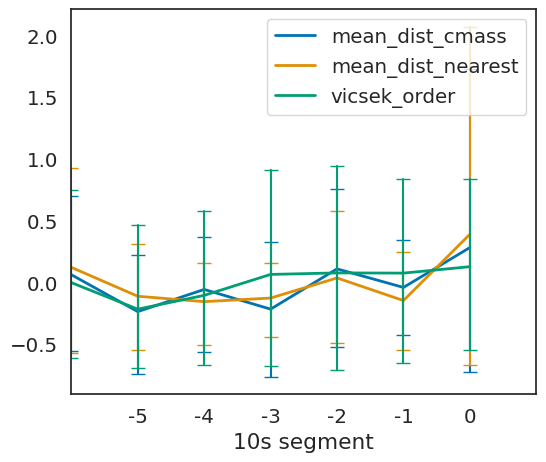

In [35]:
plot_segment_order_compare(smelt, ['mean_dist_cmass', 'mean_dist_nearest', 'vicsek_order'], emerged = 0)

In [68]:
def plot_segment_group(smelt, param, ylab, groups = [], emerged = 1):
    plt.rcParams['figure.figsize'] = 8,3

    if not groups:
        groups = smelt[smelt.Emerged == emerged].Group.unique()
    for g in groups:
        mmean = float(smelt[smelt.variable == param].value.mean())
        mstd  = float(smelt[smelt.variable == param].value.std())
        sstd  = float(smelt[smelt.variable == f"std_{param}"].value.std())

        xdat = smelt[smelt.variable == param]
        xerr = smelt[smelt.variable == f"std_{param}"]
        plt.errorbar(x = xdat[xdat.Group == g].Segment, y = (xdat[xdat.Group == g].value), 
                     yerr = (xerr[xerr.Group == g].value),
                     label = g,
                     marker = 'o', alpha = 0.7, capsize = 5)
    plt.xticks(range(0, 8), range(-7, 1))
    plt.legend(loc='upper right')
    plt.xlabel('10s segment');
    plt.ylabel(ylab);
    plt.tight_layout()

We can plot group by group to identify the variance in different dynamics.

#### `Emerged=1`

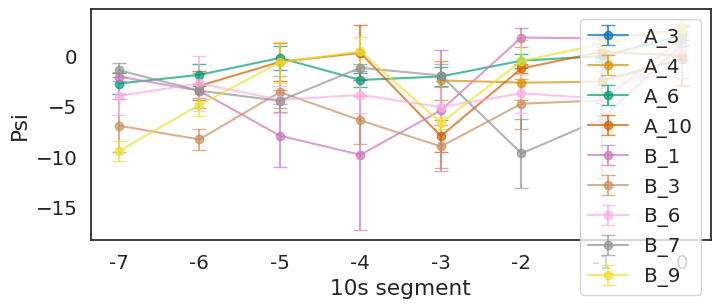

In [37]:
plot_segment_group(smelt,'psi', ylab = 'Psi', emerged = 1)

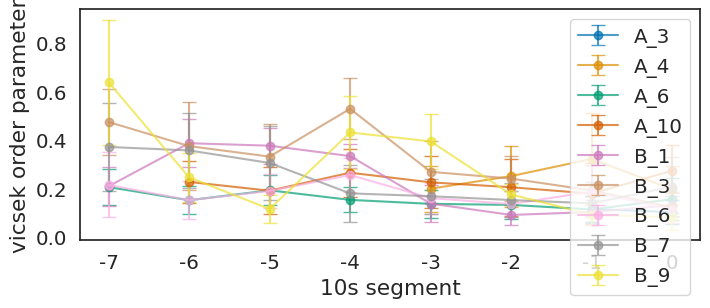

In [38]:
plot_segment_group(smelt,'vicsek_order', ylab = 'vicsek order parameter', emerged = 1)

#### `Emerged=0`

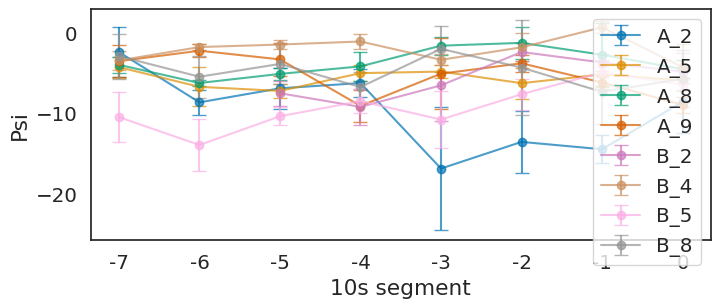

In [39]:
plot_segment_group(smelt,'psi', ylab = 'Psi', emerged = 0)

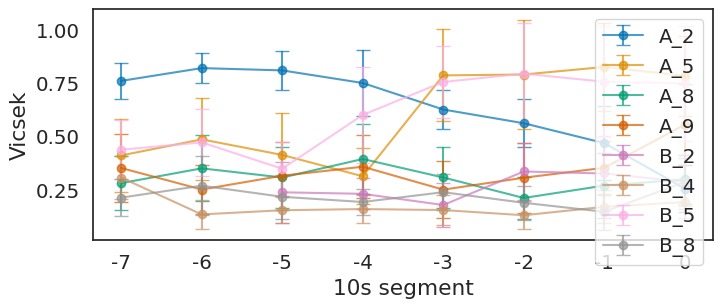

In [40]:
plot_segment_group(smelt,'vicsek_order', ylab = 'Vicsek', emerged = 0)

## Order parameter data

We also study the evolution over time of the flocking quantifiers. We pick the last 30 seconds of data from all the games and plot instantaneous order parameters.

In [41]:
def get_collapse_ordp(df_dict, param, duration, groups = []):
    df = {}        
    if not groups:
        groups = list(df_dict.keys())
        
    for g in groups:
        if not df_dict[g][param].isnull().values.any():
            df[g] = np.array(df_dict[g][param][-duration:])
            if param == 'var_angle': # hack: needs to be std dev not variance
                df[g] = np.sqrt(df[g])
            # standardise data
            #df[g] = (df[g] - np.nanmean(df[g])) / np.std(df[g])
        else:
            groups.remove(g)
                
    data = pd.DataFrame.from_dict(df, orient = 'index').transpose()
    data['timeindex'] = range(1 - duration, 1)
    data = data.melt(id_vars = 'timeindex')
    data['Emerged'] = data.variable.apply(lambda x: group.loc[x].Emerged)
    # do I need to remove manual?
    data['Manual']  = data.variable.apply(lambda x: group.loc[x].Manual)

    return data

In [42]:
def get_collapse_psi(df_dict, duration, groups = []):
    df = {}        
    if not groups:
        groups = list(df_dict.keys())
        
    for g in groups:
        if not np.isnan(df_dict[g]).all():
            df[g] = np.array(df_dict[g][-duration:])
            # standardise data
            #df[g] = (df[g] - np.nanmean(df[g])) / np.std(df[g])
        else:
            groups.remove(g)
                
    data = pd.DataFrame.from_dict(df, orient = 'index').transpose()
    data['timeindex'] = range(1 - duration, 1)
    data = data.melt(id_vars = 'timeindex')
    data['Emerged'] = data.variable.apply(lambda x: group.loc[x].Emerged)
    # do I need to remove manual?
    data['Manual']  = data.variable.apply(lambda x: group.loc[x].Manual)
    
    return data

In [43]:
collapse = dict()
collapse['vicsek_order'] = get_collapse_ordp(ordp_dfs, 'vicsek_order', 30 * 12)
collapse['mean_dist_nearest'] = get_collapse_ordp(ordp_dfs, 'mean_dist_nearest', 30 * 12)
collapse['mean_dist_cmass'] = get_collapse_ordp(ordp_dfs, 'mean_dist_cmass', 30 * 12)
collapse['std_angle'] = get_collapse_ordp(ordp_dfs, 'var_angle', 30 * 12)

collapse['psi'] = get_collapse_psi(psi, 30 * 12)

In [44]:
collapse['vicsek_order']

,timeindex,variable,value,Emerged,Manual
0,-359,A_10,0.273695,1.0,0.0
1,-358,A_10,0.333371,1.0,0.0
2,-357,A_10,0.275404,1.0,0.0
3,-356,A_10,0.251712,1.0,0.0
4,-355,A_10,0.277985,1.0,0.0
...,...,...,...,...,...
6115,-4,B_9,0.070730,1.0,0.0
6116,-3,B_9,0.093692,1.0,0.0
6117,-2,B_9,0.209972,1.0,0.0
6118,-1,B_9,0.212000,1.0,0.0


In [64]:
def plot_groups_vs_time(smelt, ylab, groups = []):
    plt.rcParams['figure.figsize'] = 8,4
    smelt = smelt[smelt.Manual == 0]

    if not groups:
        groups = smelt.variable.unique()

    for g in groups:
        sns.lineplot(x = smelt[smelt.variable == g].timeindex, y = smelt[smelt.variable == g].value)
    
    times = smelt.timeindex.unique()
    time  = int(len(times) / FRAMERATE)
    plt.xticks(times[::int(FRAMERATE * 5)], range(-time, 0, 5))
    plt.ylabel(ylab)
    plt.xlabel('seconds before end of gameplay')
    plt.tight_layout()

In [87]:
def plot_merged_vs_time(smelt, ylab, legend = False):
    plt.rcParams['figure.figsize'] = 8,4
    smelt = smelt[smelt.Manual == 0]
    
    sns.lineplot(x="timeindex", y="value", hue="Emerged", style='Emerged', data=smelt, 
                 err_style="bars", markers = True, dashes = False, linewidth = 2)
                #errorbar=("se", 2))
        
    if not legend:
        plt.legend('')
    times = smelt.timeindex.unique()
    time  = int(len(times) / FRAMERATE)
    plt.xticks(times[::int(FRAMERATE * 5)], range(-time, 0, 5))
    plt.ylabel(ylab)
    plt.xlabel('seconds before end of gameplay')
    plt.tight_layout()

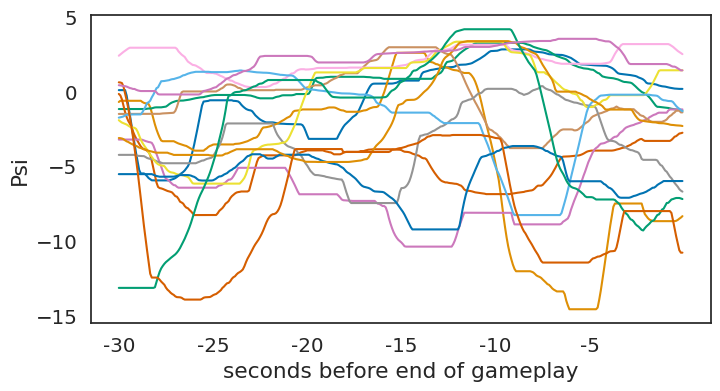

In [47]:
plot_groups_vs_time(collapse['psi'], 'Psi')

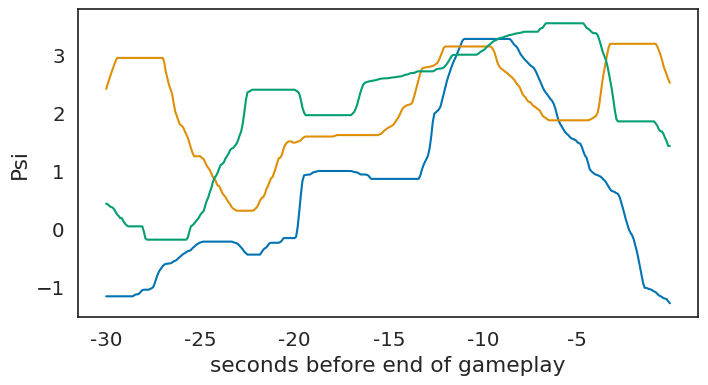

In [48]:
plot_groups_vs_time(collapse['psi'], 'Psi', ['A_6', 'B_1', 'B_9'] )

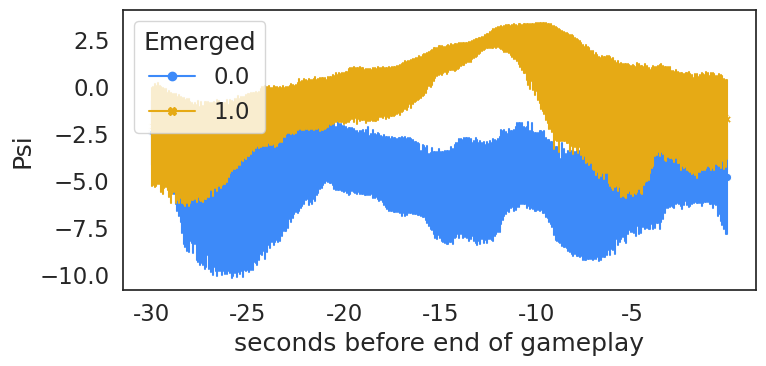

In [88]:
plot_merged_vs_time(collapse['psi'], 'Psi', legend = True)

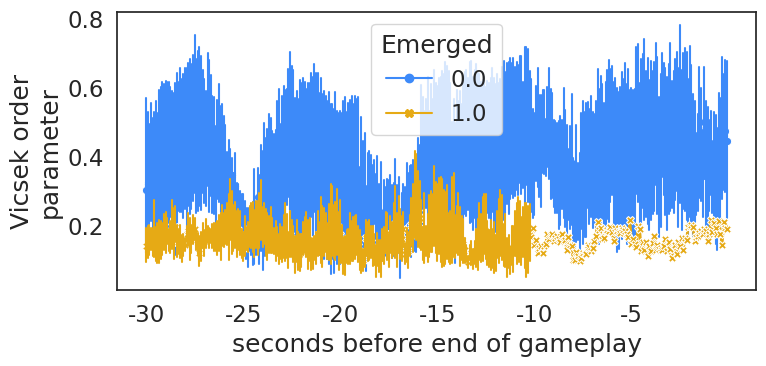

In [89]:
plot_merged_vs_time(collapse['vicsek_order'], 'Vicsek order\nparameter', legend = True)

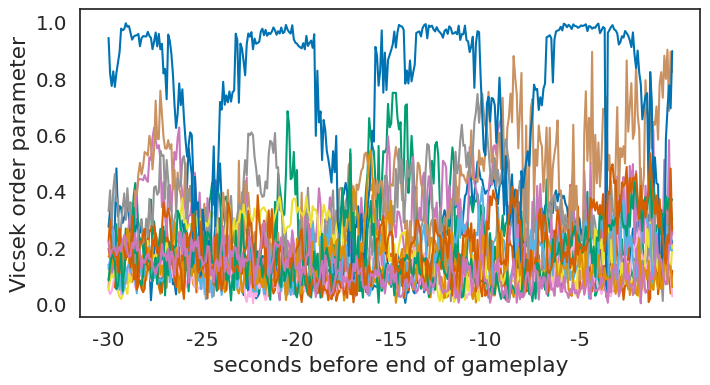

In [51]:
plot_groups_vs_time(collapse['vicsek_order'], 'Vicsek order parameter')

# Poster plots

In [52]:
sns.set(font_scale = 1.5) 
sns.set_palette('colorblind')
sns.set_style('white')

In [53]:
cols = [ "#E6AA15","#3d8af9", "#26262d", "#1930B0", ]
#pal = sns.color_palette([mcolors.to_rgba(c) for c in [ "#E6AA15","#0a9ee2", "#26262d", "#1930B0", ]] )
pal = sns.color_palette([mcolors.to_rgba(c) for c in [ "#E6AA15","#3d8af9", "#26262d", "#1930B0", ]] )
pal2 = sns.color_palette([mcolors.to_rgba(c) for c in [ "#3d8af9", "#E6AA15", "#26262d", "#1930B0", ]] )
sns.set_palette(pal2)
pal

[(0.9019607843137255, 0.6666666666666666, 0.08235294117647059),
 (0.23921568627450981, 0.5411764705882353, 0.9764705882352941),
 (0.14901960784313725, 0.14901960784313725, 0.17647058823529413),
 (0.09803921568627451, 0.18823529411764706, 0.6901960784313725)]

In [54]:
# Colourblind swatch centered on synch.live blue #0a9ee2 generated by 
# https://color.adobe.com/create/color-accessibility

In [55]:
ps = [ 'psi' ] + ordp_names + [ 'std_psi' ] + [ f'std_{p}' for p in ordp_names ]
ps

['psi',
 'mean_dist_cmass',
 'mean_dist_nearest',
 'var_angle',
 'vicsek_order',
 'std_psi',
 'std_mean_dist_cmass',
 'std_mean_dist_nearest',
 'std_var_angle',
 'std_vicsek_order']

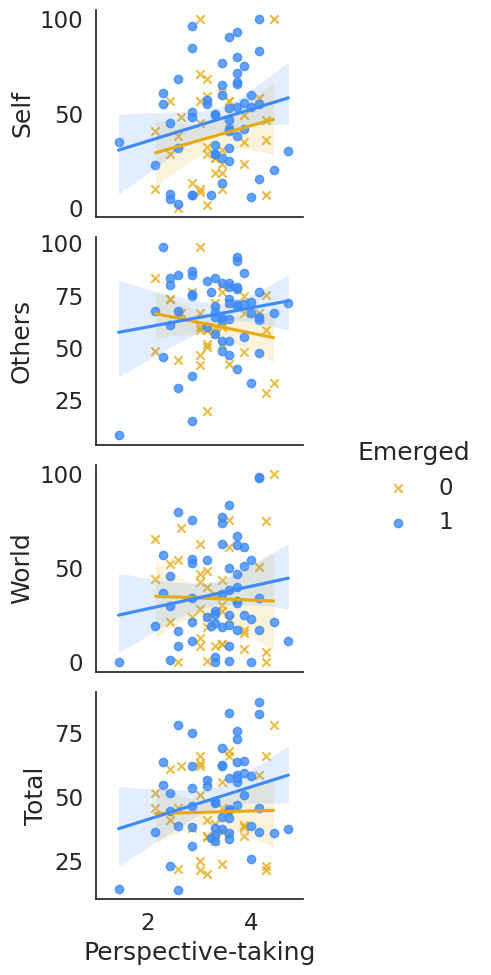

In [56]:
fig = sns.pairplot(player[player['Manual'] == 0],
                    y_vars = psych_names[1:5], x_vars = psych_names[0],
                    kind="reg", hue="Emerged",  markers = ['x', 'o'], palette = pal, 
                    diag_kind = None) # fix bug with dissapearing first graph
for ax, lbl in zip(fig.axes.flatten(), ['Self', 'Others', 'World', 'Total']):
    ax.set_ylabel(lbl)
    ax.set_facecolor('white')
fig.fig.set_size_inches(5,10)
plt.xlim(1,5)
plt.xlabel('Perspective-taking')
fig.tight_layout()

plt.savefig('../figs/davis-vs-watts.svg')

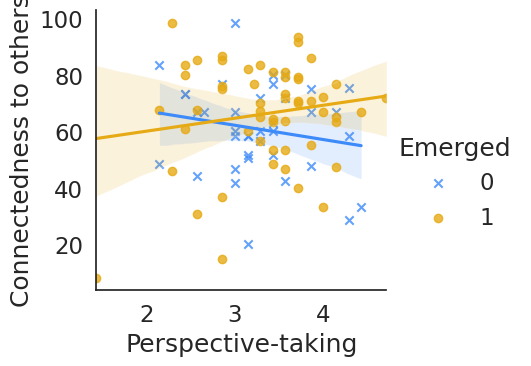

In [57]:
fig = sns.lmplot(data = player[player.Manual == 0], 
             x = 'DavisPerspective', y =  "WattsOthers",
             hue="Emerged", markers = ['x', 'o'], palette=pal2)
fig.fig.set_size_inches(5.5,4)
plt.xlabel('Perspective-taking')
plt.ylabel('Connectedness to others')
fig.tight_layout()

plt.savefig('../figs/davis_vs_wattsothers.svg')

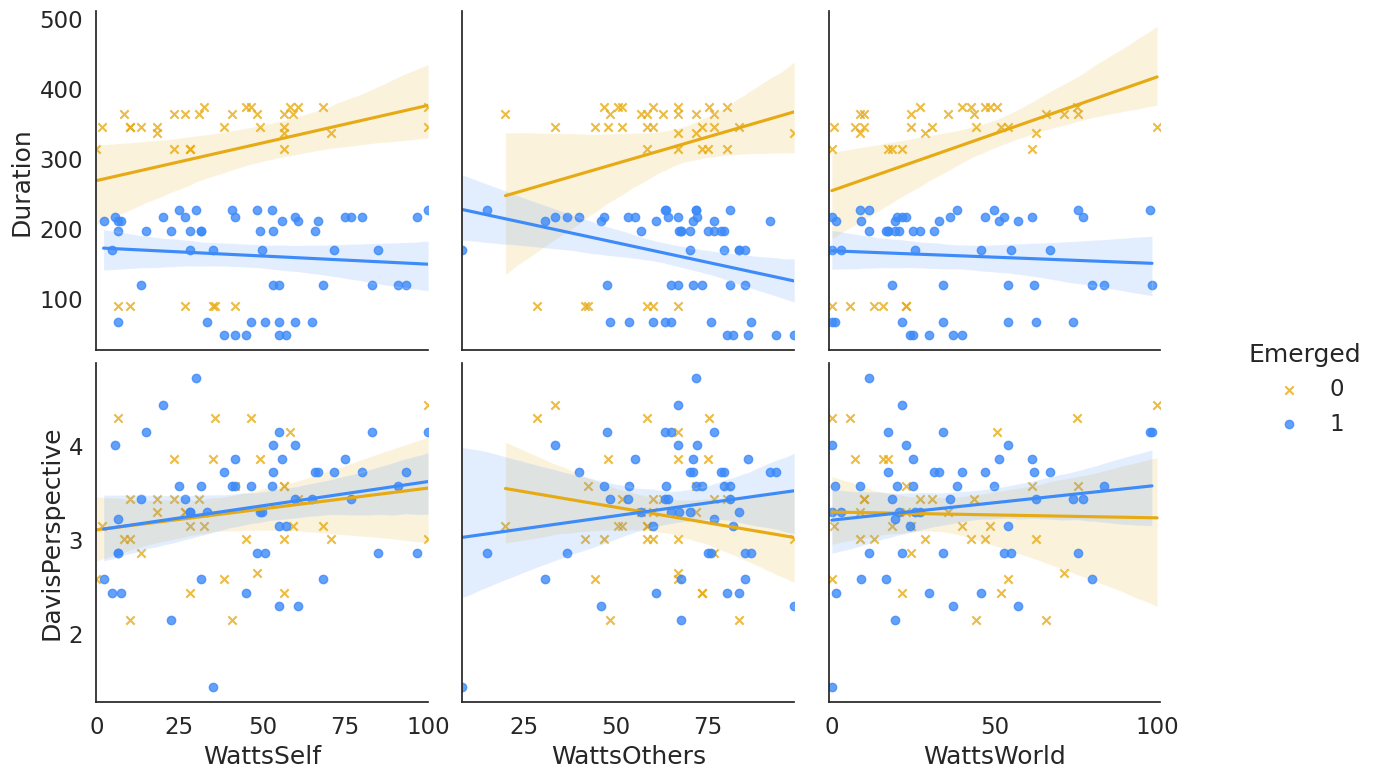

In [58]:
fig = sns.pairplot(player[player['Manual'] == 0],
                    x_vars = ['WattsSelf', 'WattsOthers', 'WattsWorld'], y_vars = [ 'Duration', 'DavisPerspective' ],
                    kind="reg", hue="Emerged", markers = ['x', 'o'], height = 3,  palette = pal, 
                    diag_kind = None) # fix bug with dissapearing first graph


fig.fig.set_size_inches(14,8)
plt.xlim(-1,101)
fig.tight_layout()

plt.savefig('../figs/watts-vs-davis-dur.svg')

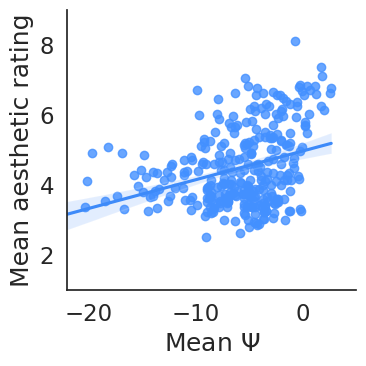

In [59]:
fig = sns.lmplot(data = segm, 
             x = 'mean_psi', y =  "mean_beauty",
             line_kws = {'color': '#3d8af9'},
             scatter_kws = {'color': '#4390ff'})
fig.fig.set_size_inches(4,4)
plt.xlabel('Mean $\\Psi$')
plt.ylabel('Mean aesthetic rating')
plt.xlim(-22, 5)
plt.ylim(1, 9)
plt.tight_layout()

plt.savefig('../figs/psi_vs_beauty.svg')

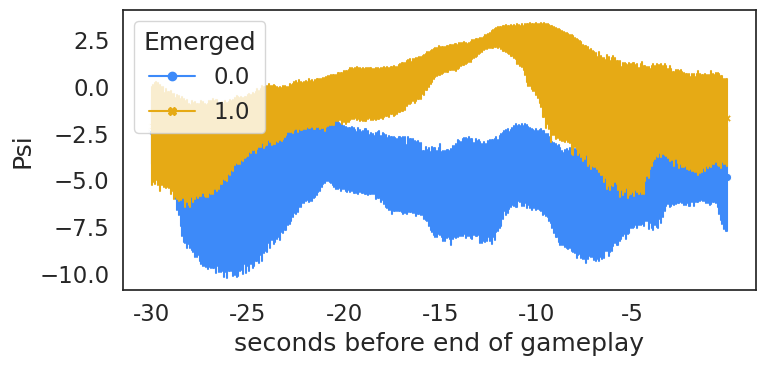

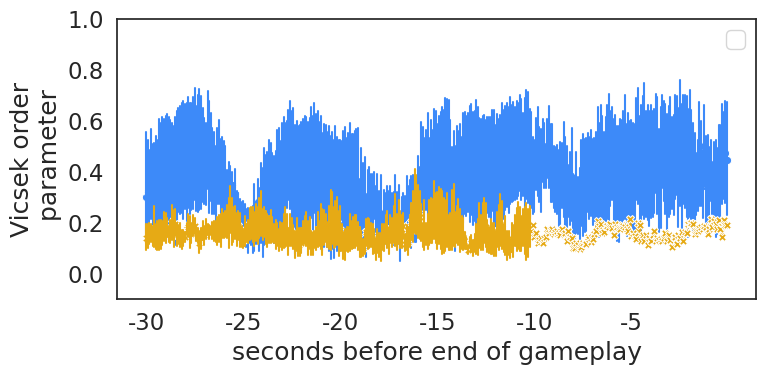

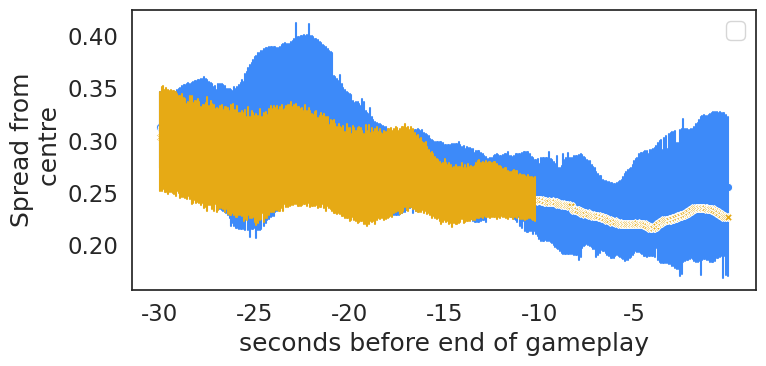

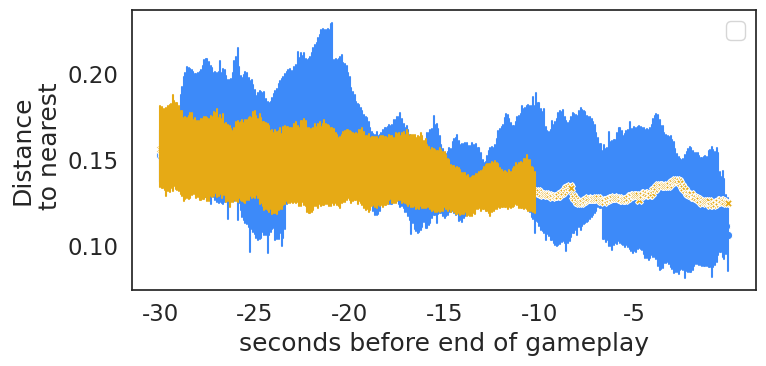

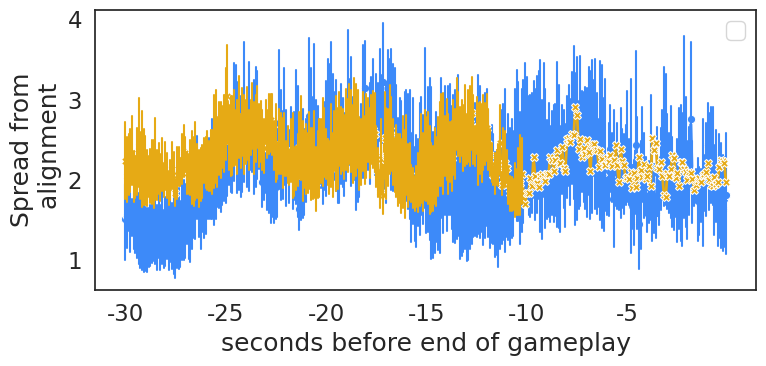

In [72]:
plot_merged_vs_time(collapse['psi'], 'Psi', legend=True)
plt.savefig('../figs/time-psi-grouped.pdf')
plt.show()

plot_merged_vs_time(collapse['vicsek_order'], 'Vicsek order\n parameter')
plt.ylim([-0.1,1])
plt.savefig('../figs/time-vicsek-grouped.pdf')
plt.show()

plot_merged_vs_time(collapse['mean_dist_cmass'], 'Spread from\n centre')
plt.savefig('../figs/time-distcentre-grouped.pdf')
plt.show()

plot_merged_vs_time(collapse['mean_dist_nearest'], 'Distance\n to nearest')
plt.savefig('../figs/time-distnearest-grouped.pdf')
plt.show()

plot_merged_vs_time(collapse['std_angle'], 'Spread from\n alignment')
plt.savefig('../figs/time-stdangle-grouped.pdf')
plt.show()

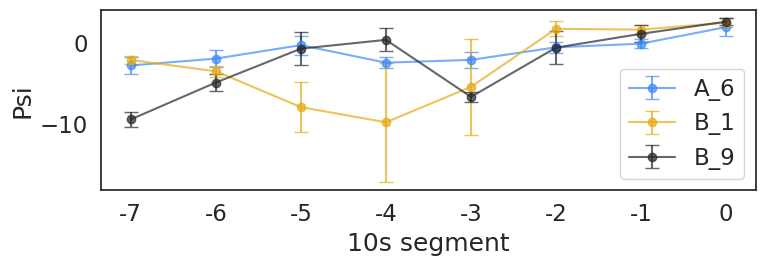

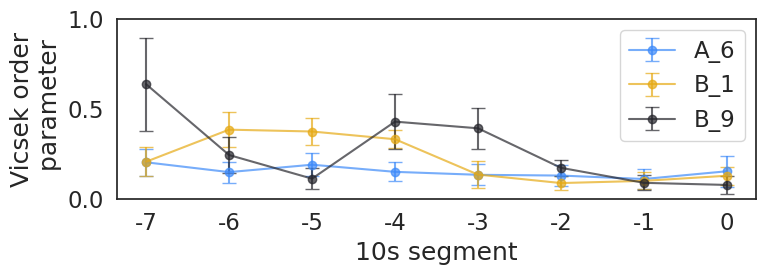

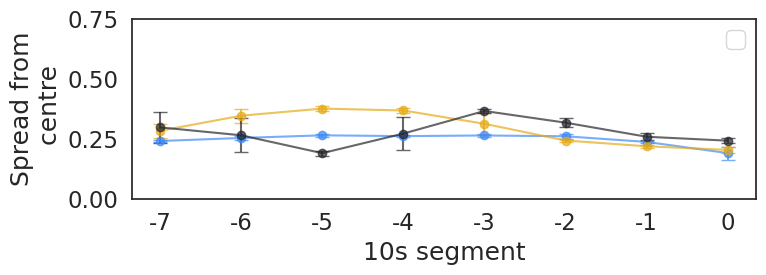

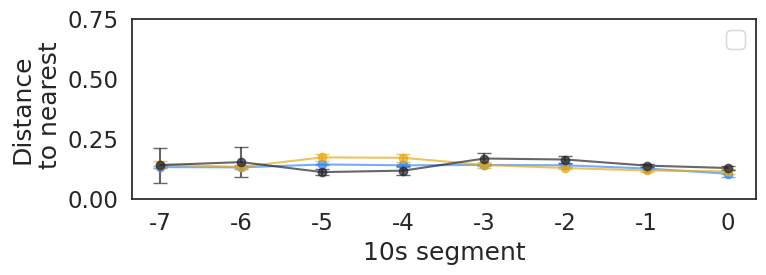

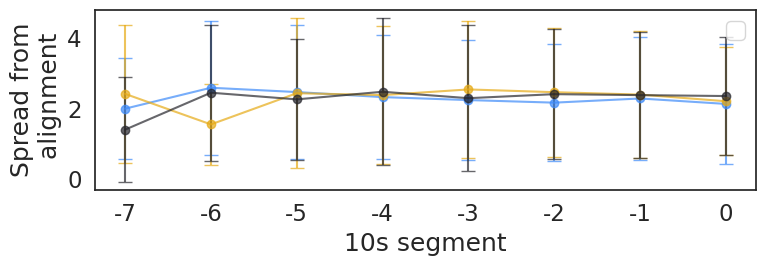

In [70]:
plot_segment_group(smelt, 'psi', 'Psi', ['A_6', 'B_1', 'B_9'])
plt.legend(loc = 'lower right')
plt.savefig('../figs/segment-psi-emerged-groups.svg')
plt.show()

plot_segment_group(smelt, 'vicsek_order', 'Vicsek order\n parameter',['A_6', 'B_1', 'B_9'])
plt.savefig('../figs/segment-vicsek-emerged-groups.svg')
plt.ylim([0, 1])
plt.show()

plot_segment_group(smelt, 'mean_dist_cmass', 'Spread from\n centre',    ['A_6', 'B_1', 'B_9'])
plt.legend('')
plt.ylim([0, 0.75])
plt.savefig('../figs/segment-distcentre-emerged-groups.svg')
plt.show()

plot_segment_group(smelt, 'mean_dist_nearest', 'Distance\n to nearest',   ['A_6', 'B_1', 'B_9'])
plt.legend('')
plt.ylim([0, 0.75])
plt.savefig('../figs/segment-distnearest-emerged-groups.svg')
plt.show()

plot_segment_group(smelt, 'std_angle', 'Spread from\n alignment',  ['A_6', 'B_1', 'B_9'])
plt.legend('')
plt.savefig('../figs/segment-stdangle-emerged-groups.svg')
plt.show()


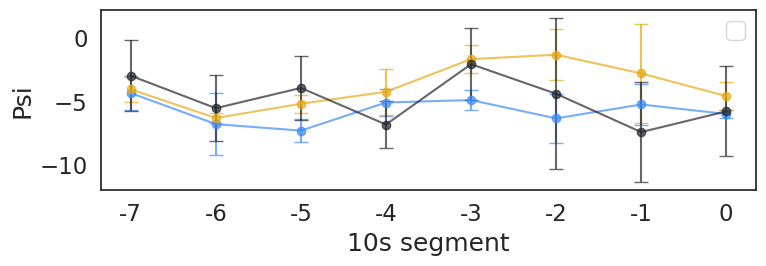

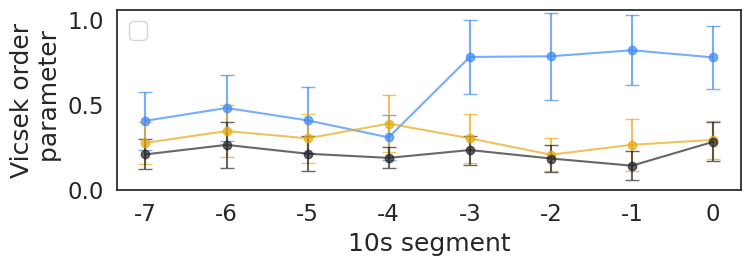

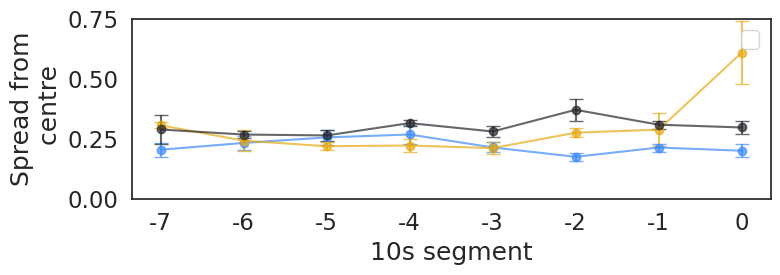

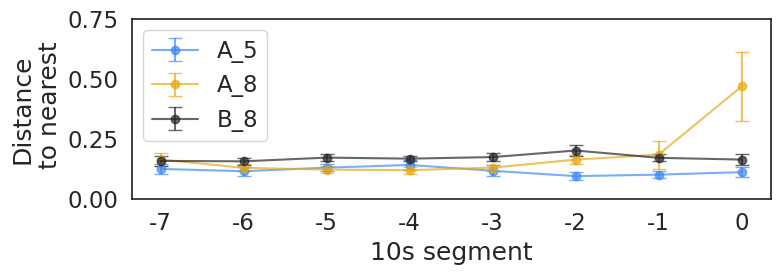

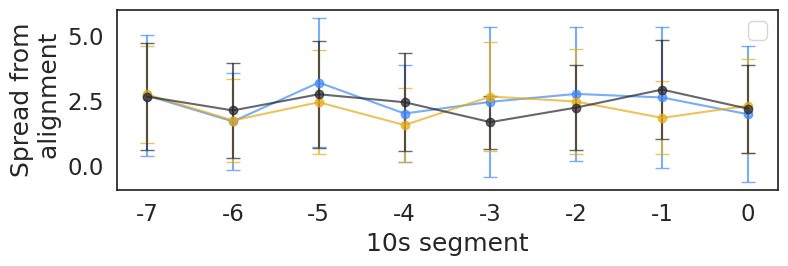

In [71]:
plot_segment_group(smelt, 'psi', 'Psi', ['A_5', 'A_8', 'B_8'])
plt.legend('')
plt.savefig('../figs/segment-psi-lost-groups.svg')
plt.show()

plot_segment_group(smelt, 'vicsek_order', 'Vicsek order\n parameter', ['A_5', 'A_8', 'B_8'])
plt.legend('')
plt.ylim([0, 1.06])
plt.savefig('../figs/segment-vicsek-lost-groups.svg')
plt.show()

plot_segment_group(smelt, 'mean_dist_cmass', 'Spread from\n centre', ['A_5', 'A_8', 'B_8'])
plt.legend('')
plt.ylim([0, 0.75])
plt.savefig('../figs/segment-distcentre-lost-groups.svg')
plt.show()

plot_segment_group(smelt, 'mean_dist_nearest', 'Distance\n to nearest', ['A_5', 'A_8', 'B_8'])
plt.legend(loc = 'upper left')
plt.ylim([0, 0.75])
plt.savefig('../figs/segment-distnearest-lost-groups.svg')
plt.show()

plot_segment_group(smelt, 'std_angle', 'Spread from\n alignment', ['A_5', 'A_8', 'B_8'])
plt.legend('')
plt.savefig('../figs/segment-stdangle-lost-groups.svg')
plt.show()
